november 4 2018
Rhondene Wint
## Predicting Gene Expression from CDS  with Deep Learning

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.utils import shuffle

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,Flatten, Input
from keras.preprocessing.text import one_hot
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [5]:
##probably won't need all of these but anyways
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Convolution1D, Dropout
from keras.models import Model
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape,  Conv1D, TimeDistributed


In [6]:
transcripts = [] #cds files 
with open('./Transcripts/cds_files.txt','r+') as f:  #list of the file names (ls *.ge > exprs_list.txt)
    for line in f:
        transcripts.append(line.strip()[:-4])

genomes=[]
""" Expand the dataframe with columns from expression data"""
with open('./exprs/exprs_data/exprs_list.txt','r+') as f:  #list of the file names (ls *.ge > exprs_list.txt)
    for line in f:
        genomes.append(line.strip()[:-11])

In [6]:
##data loading and preprocess functions
def get_data(species):
    """
    Input:
    species: type(str) name of the species you want
    
    Returns
    df_exprs: dataframe of top 10 and bottom 10 expressed genes with corresponding cds
    """
    df_exprs=pd.read_table("./exprs/exprs_data/{}_merged.csv".format(species), sep=',')
    ##read in cds
    ids=[]
    cds =[]

    with open("./Transcripts/{}.cds".format(species), 'r+') as f:
        seq = ''
        for line in f:
            if line.startswith('>'):
                ids.append(line.rstrip().split('|')[0][1:])
                if len(seq)!=0:
                    cds.append(seq)  #so the first cds isn't empty
                seq = ''
                continue
            if line[0]!='>':
                seq+=line.rstrip()
        cds.append(seq) #the last cds gets appended

    df = pd.DataFrame([ids, cds]).T  ##didnt need to make this dataframe 

    ##sort both by protein_ID
    df.sort_values(by=0,inplace=True)  #same as Protien_ID
    cds= df[1].values
    n = df_exprs.shape[0]
    df_exprs['CDS'] = cds[:n]  #the exprs tables may be shorter than cds files since all genes may not be trasncirbed 

    ##choose top_10 and bottom exprs_10
    lower_10 = df_exprs['Abs_Exprs'].quantile(0.1)
    upper_10 = df_exprs['Abs_Exprs'].quantile(0.9)

    bottom_10 = df_exprs[df_exprs['Abs_Exprs']<lower_10]
    top_10 = df_exprs[df_exprs['Abs_Exprs']>upper_10]
    top_10['Exprs_Level'] = 'High'
    bottom_10['Exprs_Level'] = 'Low'

    df_exprs = pd.concat([bottom_10,top_10])
    return shuffle(df_exprs)

##preprocessing
def preproc(df,max_len):
    """return CDS and labels...inputs for neural networ"""
    df_comb = df
    codons = []
    labels = []
    for i in range(len(df_comb['CDS'].values)):
            seq = df_comb['CDS'].values[i]
            if len(seq)%3 !=0:  ##
                continue
            j=0
            c=[]
            for x in range(int(len(seq)/3)):
                codon = seq[j:j+3]
                c.append(codon)
                j+=3
                if j==(int(len(seq)/3)):break
            cods = " ".join(c)
            codons.append(cods)
            labels.append(df_comb['Exprs_Level'].values[i])
    return codons,labels

def encode_data(codons,labels,max_len):
    """ return padded_codons(feeds into embedding layer) and labels"""
    #codons_normed = StandardScaler().fit_transform(codons)  no don't scale because it is sparse vector
    vocab_size=64
    encoded_codons = [one_hot(seq,vocab_size) for seq in codons]
    from keras.preprocessing.sequence import pad_sequences
    padded_codons = pad_sequences(encoded_codons,maxlen= max_len, padding='post')
    ##one hot encode expression labels
    target = []
    for exprs in labels:
        if exprs == 'Low':
            target.append(0)
        if exprs == 'High':
            target.append(1)
    target = np.asarray(target)
    return padded_codons, target

In [10]:
##gets combined data from multiple transcriptomes..eg all members of a family 
def combined_genomes(names):
    """ names is the list or array of species names
    returns concatenated dataframe of the cds and corresponding exprs of the species """
    df_list = []
    for species in doth:
        try:
            if species not in transcripts:   #ensure that the expression file has corresponding CDS file 
                continue
            #load exprssion data
            df_exprs=pd.read_table("./exprs/exprs_data/{}_merged.csv".format(species), sep=',')

            ##read in cds
            ids=[]
            cds =[]

            with open("./Transcripts/{}.cds".format(species), 'r+') as f:
                seq = ''
                for line in f:
                    if line.startswith('>'):
                        ids.append(line.rstrip().split('|')[0][1:])
                        if len(seq)!=0:
                            cds.append(seq)  #so the first cds isn't empty
                        seq = ''
                        continue
                    if line[0]!='>':
                        seq+=line.rstrip()
                cds.append(seq) #the last cds gets appended

            df = pd.DataFrame([ids, cds]).T  ##didnt need to make this dataframe 

            ##sort both by protein_ID
            df.sort_values(by=0,inplace=True)  #same as Protien_ID
            cds = df[1].values
            n = df_exprs.shape[0]
            df_exprs['CDS'] = cds[:n]  #the exprs tables may be shorter than cds files since all genes may not be trasncirbed 

            ##choose top_10 and bottom exprs_10
            lower_10 = df_exprs['Abs_Exprs'].quantile(0.1)
            upper_10 = df_exprs['Abs_Exprs'].quantile(0.9)

            bottom_10 = df_exprs[df_exprs['Abs_Exprs']<lower_10]
            top_10 = df_exprs[df_exprs['Abs_Exprs']>upper_10]
            top_10['Exprs_Level'] = 'High'
            bottom_10['Exprs_Level'] = 'Low'

            df_exprs = pd.concat([bottom_10,top_10])
            df_list.append(df_exprs)
        except FileNotFoundError:
            continue
        return pd.concat(df_list)

In [7]:
def train_plot(history):
    """plots training history for networ"""
    plt.figure(figsize=(8,8))
    plt.plot(history.history['acc'], linewidth=4)
    plt.plot(history.history['val_acc'], linewidth=4)
    plt.title('Neural Network Accuracy for Predicting Gene Expression from Coding Sequence from',
              fontsize=16, fontweight='bold')
    plt.ylabel('Prediction Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.legend(['Train_set', 'Test_set'], loc='upper left')
    plt.show()

In [15]:
max_len = 2000 #2000 codons

In [72]:
df_comb = get_data(genomes[22])
codons,labels=preproc(df_comb,max_len)
padded_codons,target = encode_data(codons,labels,max_len)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
padded_codons.shape

(2360, 2000)

In [11]:
import random

In [12]:
random.seed(123)

In [13]:
model = Sequential()
model.add(Embedding(64,8, input_length=max_len))
model.add(Flatten())   #unroll 3d tensor into 1-d 
model.add(Dense(1,activation='sigmoid'))  ##output layer is only one layer because either 1 or low

#compile the model
model.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
                   metrics=['accuracy'], loss='binary_crossentropy')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 8)           512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16001     
Total params: 16,513
Trainable params: 16,513
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
from timeit import default_timer as timer

In [17]:
start= timer()
history = model.fit(padded_codons, target, validation_split=0.33, epochs=150, batch_size=32, verbose=0)
duration= timer()-start
loss,accuracy = model.evaluate(padded_codons, target,verbose=1)
print('Accuracy: ', (accuracy*100))

2360/2360 [==============================] - 0s 113us/step
Accuracy:  88.72881355932203


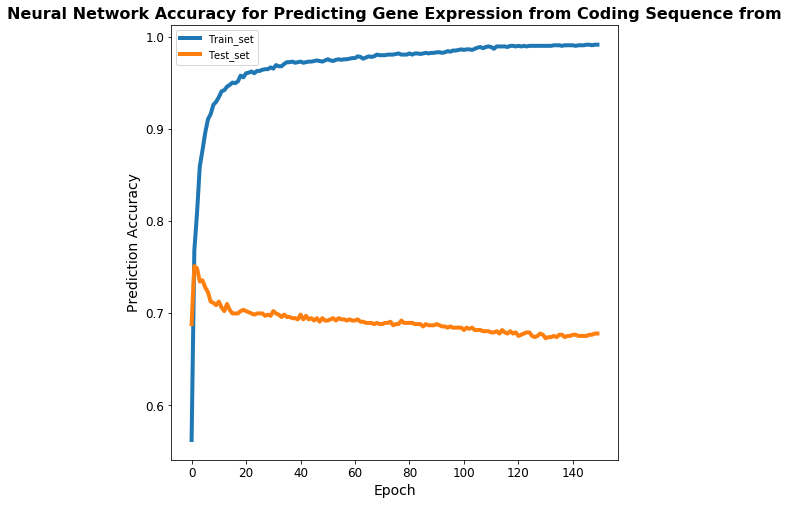

In [22]:
train_plot(history)

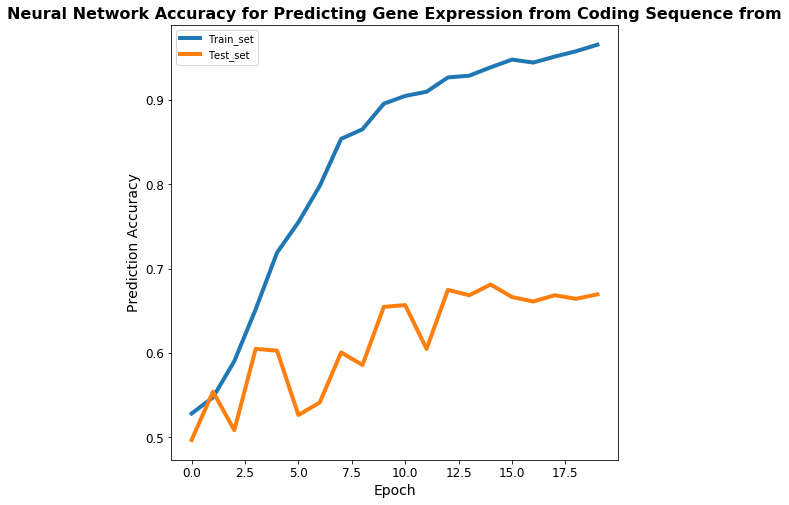

In [23]:
model = Sequential()
model.add(Embedding(64,8, input_length=max_len,embeddings_initializer='glorot_normal'))
model.add(Flatten())   #unroll 3d tensor into 1-d 
model.add(Dense(1,activation='sigmoid'))  ##output layer is only one layer because either 1 or low

#compile the model
model.compile(optimizer='rmsprop',
                   metrics=['accuracy'], loss='mse')
start= timer()
history = model.fit(padded_codons, target, validation_split=0.4, epochs=20, verbose=0)
duration = timer()-start
loss,accuracy = model.evaluate(padded_codons, target,verbose=0)
train_plot(history)

In [24]:
accuracy

0.8504237290156089

### try bidirectional lstm 
#### modified from my deepai course 

In [100]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)  # feature slection with 1-dim convolutional layer
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                               # ReLu activation
    X = Dropout(0.8)(X)                               # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                               # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                   # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [38]:
padded_codons.shape

(2360, 2000)

In [43]:
target=np.asarray(target)

In [46]:
target.shape

(2360,)

In [51]:
batch_size = 64
epochs=120
timesteps=20 #use the last 20 codons to predict the next 20 codons

In [48]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [107]:
length = get_train_length(padded_codons, batch_size, 0.2) 
print(length)

1792
1856
1856


In [108]:
#Adding timesteps * 2
upper_train = length + timesteps*2
padded_codons_train = padded_codons[0:upper_train]
X =padded_codons_train[:,1:2]
X.shape

(1896, 1)

In [106]:
X[0]

array([[46]])

In [109]:
# Creating a data structure with n timesteps
X_train = []
y_train = []

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(X[i-timesteps:i,0])
    y_train.append(X[i:i+timesteps,0])

1876


In [110]:
print( np.array(X_train).shape)
print (np.array(y_train).shape)

(1856, 20)
(1856, 20)


In [115]:
###reshape the 2-d to 3-D for conv1d input
padded_codons = np.reshape(padded_codons, (padded_codons.shape[0], padded_codons.shape[1], 1))
#target = np.reshape(target, (target.shape[0], target.shape[1], 1))
print(padded_codons.shape)
print(target.shape)

(2360, 2000, 1)


AttributeError: 'list' object has no attribute 'shape'

In [68]:
(X_train.shape)

(1856, 20, 1)

In [112]:
padded_codons.shape

(2360, 2000)

In [79]:
type(padded_codons.shape)

tuple

In [101]:
input_shape = (20,1)
type(input_shape)

tuple

In [102]:
model = model(input_shape = (20,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2, 196)            3136      
_________________________________________________________________
batch_normalization_13 (Batc (None, 2, 196)            784       
_________________________________________________________________
activation_5 (Activation)    (None, 2, 196)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2, 196)            0         
_________________________________________________________________
gru_9 (GRU)                  (None, 2, 128)            124800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 2, 128)            0         
__________

In [ ]:
model.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
                   metrics=['accuracy'], loss='binary_crossentropy')
start= timer()
history = model.fit(padded_codons, target, validation_split=0.4, epochs=20, verbose=0)
duration = timer()-start
loss,accuracy = model.evaluate(padded_codons, target,verbose=0)
train_plot(history)

In [117]:
padded_codons.shape

(2360, 2000, 1)

In [118]:
df_comb = get_data(genomes[22])
codons,labels=preproc(df_comb,max_len)
padded_codons,target = encode_data(codons,labels,max_len)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
target= np.squeeze(np.asarray(target))
target = target.reshape(target.shape[0],1)
target.shape

(2360, 1)

In [136]:
model = Sequential()
model.add(Embedding(2000,128, input_length = padded_codons.shape[1]))
model.add(Bidirectional(LSTM(10, dropout_U = 0.2, dropout_W = 0.2)))
model.add(Dense(1, activation = 'softmax'))

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [137]:
model.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
                   metrics=['accuracy'], loss='binary_crossentropy')

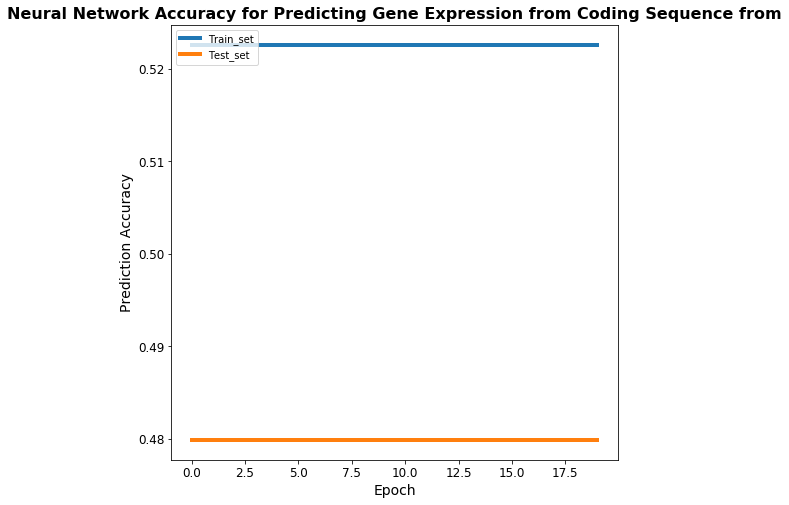

In [138]:
start= timer()
history = model.fit(padded_codons, target, validation_split=0.4, epochs=20, verbose=0)
duration = timer()-start
loss,accuracy = model.evaluate(padded_codons, target,verbose=0)
train_plot(history)

In [139]:
duration

2810.3111524869346